<center>
    <h1> Proyecto #1 - Multigrid </h1>
    <h4 style="margin:10px;"> IPM-407 - Modelación Computacional con Algoritmos Rápidos </h4>
    <h3> Hernán Vargas -- 201073009-3 </h3>
    <h4 style="margin:5px;"> hernan.vargas@alumnos.usm.cl </h4>
</center>

La ecuación diferencial

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -2\big((1-6x^2)y^2(1-y^2)+(1-6y^2)x^2(1-x^2)\big) $$

con $u = 0$ en $x=0, x=1, y=0, y=1$ y $0<x, y<1$ tiene como solución analítica:

$$ u(x,y) = (x^2-x^4)(y^4 - y^2) $$

Resuelva la ecuación diferencial númericamente con una discretización de segundo orden, usando:
1. Gauss-Seidel.
2. V-cycle, con $v_1=2$ y $v_2=2$ iteraciones subiendo y bajando en las mallas.
3. Multigrid, con $v_0=1$ V-cycle por malla.

Considere lo siguiente:
- Malla fina con 129 nodos por dimensión ($\Delta x = \frac{L}{N-1}$).
- Interpolación lineal y *full weightening* como operadores entre mallas.
- Tolerancia de $10^{-8}$ del residual

Además debe:
- Indicar el número de iteraciones, V-cycles, multigrids necesarios para llegar a la solución en cada caso.
- Indicar el tiempo de solución en cada caso ¿Se cumple la predicción téorica que vimos en clases? (recuerde que cualificamos la cantidad de operaciones por unidad de ciclos de Gauss-Seidel)
- Realizar simulaciones con malla fina de 65, 129, 257 nodos por dimensión usando V-cycles y Multigrid, y graficar el tiempo de solución versus el tamaño de malla fina (gráfico *log-log*) ¿Se cumple la complejidad algoritmica que derivamos en clase?
- Estudie el efecto de varias $v_0, v_1$ y $v_2$ ¿Puede proponer una combinación ideal?
- Estudie el efecto de cambiar *full weightening* por *injection*.

## Introducción
Primero se definen las variables, constantes y consideraciones.

In [1]:
import numpy as np;
import scipy as sp;
from scipy import linalg;
from scipy import sparse;
from scipy.sparse import linalg;
import matplotlib;
import matplotlib.pyplot as plt;
import time;

In [2]:
sol    = lambda x,y: (x**2 - x**4)*(y**4 - y**2); # Solución analítica.
nodes  = [65, 129, 257];                # Número de nodos de los experimentos.
TOL    = 1e-8;                          # Tolerancia del residual.
MAXIT  = 1000;                          # Iteraciones máximas.
L      = 1;                             # Largo de la malla, en este caso (1 - 0) para x e y
get_dx = lambda N: (L / (N-1));         # Distancia entre los puntos

La ecuación con la que trabajamos puede ser representada como:
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = g(x,y) $$
con:
$$ g(x,y) = -2\big((1-6x^2)y^2(1-y^2)+(1-6y^2)x^2(1-x^2)\big) $$

In [3]:
g   = lambda x,y: -2*(((1-(6*x**2))*(y**2)*(1-y**2)) + ((1-(6*y**2))*(x**2)*(1-x**2)));

Sea la interpolación de segundo orden para las derivadas de $u$:

$$ \frac{\partial^2 u}{\partial x^2} = \frac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{\Delta x^2} $$
$$ \frac{\partial^2 u}{\partial y^2} = \frac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{\Delta y^2} $$

luego:

$$ \frac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{\Delta x^2} + 
   \frac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{\Delta y^2} = g(x_i,y_j)$$

Para nuestro caso sabemos $\Delta x =\Delta y = \Delta$, luego:

$$ -4u_{i,j} + u_{i-1,j} + u_{i+1,j} + u_{i,j-1}+u_{i,j+1} = \Delta^2 g(x_i,y_j)$$

Podemos crear el sistema de ecuaciones $A\vec{x} = \vec{b}$ con:

$$
A = \left( \begin{array}{ccc}
  D & I &   &   & \\
  I & D & I &   & \\
    & I & \ddots & \ddots & \\
    &   & \ddots & \ddots & I \\
    & &   & I & D \\
\end{array} \right)_{(n-2) \times (n-2)}
$$

$$ \vec{x} = [u_{1,1},u_{2,1},\dots, u_{n,1}, u_{1,2}, \dots, u_{n-1,n-1}]^{T} $$
$$ \vec{b} = [\Delta ^2 g(x_1,y_1), \Delta ^2 g(x_2,y_1), \dots,
              \Delta ^2 g(x_{n-1},y_{n-1})]^{T} $$

Donde: (n-2)x(n-2) TODO
$$
D = \left( \begin{array}{ccc}
  -4 &  1 & & & \\
   1 & -4 & 1 & & \\
     & \ddots & \ddots &\ddots  & \\
     & & \ddots &\ddots &  1 \\
     & & & 1 & -4 
\end{array} \right)_{(n-2)\times(n-2)}\,\,\,
I = \left( \begin{array}{ccc}
  1 &  & \\
   & \ddots &  \\
   &  & 1
\end{array} \right)_{(n-2)\times(n-2)}
$$

In [4]:
def get_A(n, sparse = False):
    """ Crea la matriz laplaciana para un problema con bordes 0.
    Como los bordes son 0 no se guardan.
    Argumentos:
        n      -- Número de puntos por dimensión.
        sparse -- (Opcional) Si es verdadero se crea una matriz sparse.
    Retorna: Matriz laplaciana de (n-2)^2 x (n-2)*2
    """
    if n < 3: return None;
    n = n-2
    if not sparse:
        D = np.diag(-4* np.ones(n)) + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1);
        return sp.linalg.block_diag(*[D]*n) + np.diag(np.ones(n*(n-1)), n) + np.diag(np.ones(n*(n-1)), -n);
    else:
        N = n**2;
        main_diag = np.ones(N)*-4.0;
        side_diag = np.ones(N-1);
        up_down_diag = np.ones(N-3);
        side_diag[np.arange(1,N)%n==0] = 0;
        return sp.sparse.diags([main_diag,side_diag,side_diag,up_down_diag,up_down_diag], [0, -1, 1,n,-n], format="csc");

In [5]:
def get_b(n):
    """ Crea el vector b, con el lado derecho de la ecuación g(x,y)*dx^2.
    Como las condiciones de borde son 0 no las guarda.
    Argumentos:
        n -- Número de puntos por dimensión.
    Retorna: Vector de (n-2)**2 elementos.
    """
    dx = get_dx(n);
    b  = np.zeros((n-2)**2);
    for j in range(n-1):
        for i in range(n-1):
            b[(j-1)*(n-2) + (i-1)] = (dx**2) * g(dx*i, dx*j);
    return b;

## Gauss-Seidel
Podemos resolver el sistema $A\vec{x} = \vec{b}$ con el metodo iterativo de Gauss-Seidel. 

Sea $A = (D + L + U)$ tenemos:

\begin{align}
 A\vec{x} &= \vec{b} \\
 (D + L + U)x &= b \\
 (D + L)x &= b - Ux \\
 x^{k+1} &= (D + L)^{-1}(b - Ux^k)
\end{align}

Donde $x^{k}$ será la aproximación de la solución en la k-ésima iteración.

Podemos calcular el residual como $r = Ax - Ax^{k+1} = b - Ax^{k+1}$, luego el criterio de término del algoritmo será cuando
la norma 2 del residual sea menor a cierta tolerancia.

In [356]:
def gs(A, b, x = None, maxit = MAXIT, info = {}):
    """ Resuelve la ecuación vectorial Ax = b con el método de Gauss-Seidel.
    Argumentos:
        A      -- Matriz A.
        b      -- Vector b.
        x      -- (Opcional) Aproximación inicial, por defecto 0.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Vector con las soluciones sistema.
    """
    if not isinstance(x, np.ndarray):
        x = np.zeros_like(b);
    sparse = sp.sparse.issparse(A);
    res  = 1.0;
    info["time"] = time.time();
    if sparse:
        L  = sp.sparse.tril(A);
        Li = sp.sparse.linalg.inv(L);
        U = A - L;
        for k in range(maxit):
            x = Li.dot(b - U.dot(x));
            res = np.linalg.norm(b - A.dot(x));
            if res < TOL: break;
    else:
        L  = np.tril(A);
        Li = np.linalg.inv(L);
        U = A - L;
        for k in range(maxit):
            x = np.dot(Li, b - np.dot(U, x))
            res = np.linalg.norm(b - np.dot(A, x));
            if res < TOL: break;
    info["loop"]  = k + 1;
    info["time"]  = (time.time() - info["time"])*1000.0;
    info["res"] = res;
    info["result"] = x;
    return x;

Para poder visualizar los resultados debemos transformar el vector solución $\vec{x}$ en una matriz, para ello se definen las siguientes útilidades:

In [7]:
def mk_sol(n):
    """Crea una matriz con la solución analítica.
    Argumetos:
        n -- Número de puntos de la malla por dimensión.
    Retorna: Malla con los resultados analíticos."""
    dx = get_dx(n);
    s = np.zeros((n,n));
    for i in range(n):
        for j in range(n):
            s[i,j] = sol(dx*i, dx*j);
    return s;

In [8]:
def mk_appr(x):
    """Crea una matriz con la solución aproximada.
    Agrega las condiciones de borde que antes fueron descartadas.
    Argumetos:
        x -- vector con la solución.
    Retorna: Malla con los resultados aproximados."""
    n = int(np.sqrt(x.shape[0]) + 2);
    s = np.zeros((n,n));
    for j in range(1, n-1):
        for i in range(1, n-1):
            s[j, i] = x[(j-1)*(n-2) + (i-1)];
    return s;

Con esto podemos comenzar a probar el método. Se trabajará con una malla de 33 nodos por dimensión 
primero observemos como se ve la solución analítica:

In [9]:
n = 33;
A, b = get_A(n), get_b(n);

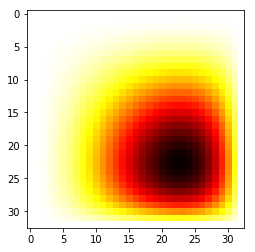

In [10]:
plt.imshow(mk_sol(n), cmap='hot'); plt.show();

Ahora resolvamos el problema con el Gauss-Seidel implementado:

In [11]:
r1 = mk_appr(gs(A, b));

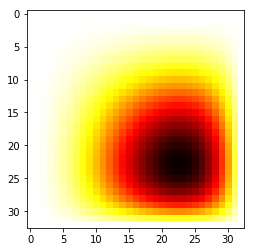

In [12]:
plt.imshow(r1, cmap='hot'); plt.show();

Como podemos notar, el método es bastante lento debido a que se hace el cálculo de una inversa.
Además, no se cumplio el criterio de término y el algoritmo paró al alcanzar el número máximo
de iteraciones, aún así la imagen es parecida al resultado analítico.

Podemos sacar la inversa del algoritmo haciendo lo siguiente:
\begin{align}
 (D + L + U)x &= b \\
 (D + L)x &= b - Ux \\
 (D + L)x^{k+1} &= b - Ux^k \\
 Dx^{k+1} &= b - Ux^k - Lx^{k+1}\\
\end{align}

Luego calculamos este resultado para cada elemento del vector $x$ iterando con la siguiente formula:

$$
x^{k+1}_i  = \frac{1}{D_{ii}} \left(b_i - \sum_{j>i}a_{ij}x^{k}_j - \sum_{j<i}a_{ij}x^{k+1}_j \right),\quad i,j=1,2,\ldots,n
$$

In [357]:
def gs2(A, b, x = None, maxit = MAXIT, info = {}):
    """ Resuelve la ecuación vectorial Ax = b con el método de Gauss-Seidel.
    Calcula el resultado del vector x iterativamente.
    Argumentos:
        A      -- Matriz A.
        b      -- Vector b.
        x      -- (Opcional) Aproximación inicial, por defecto 0.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Vector con las soluciones sistema.
    """
    if not isinstance(x, np.ndarray):
        x  = np.zeros_like(b);
    x2  = np.zeros_like(x);
    res = 1.0;
    info["time"] = time.time();
    
    for k in range(maxit):
        for i in range(A.shape[0]):
            s1 = np.dot(A[i, :i], x2[:i]);         #U
            s2 = np.dot(A[i, i + 1:], x[i + 1:]);  #L
            x2[i] = (b[i] - s1 - s2) / A[i, i];    #D
            
        res = np.linalg.norm(b - np.dot(A, x2));
        if res < TOL: break;

        x = x2;
    info["loop"] = k + 1;
    info["time"] = (time.time() - info["time"])*1000.0;
    info["res"]  = res;
    info["result"] = x;
    return x

Probamos este algoritmo con los datos usados anteriormente:

In [14]:
r2 = mk_appr(gs2(A, b));

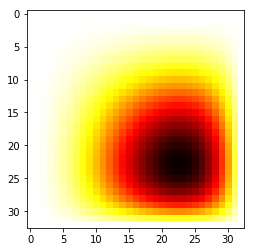

In [15]:
plt.imshow(r2, cmap='hot'); plt.show();

Como notamos, el algoritmo, a pesar de no calcular ninguna inversa, termina demorando mucho debido a 
la complejidad del trabajo con matrices. 

Otro problema de estos algoritmos es la cantidad de memoría utilizada. Para calcular la solución en una malla de $n$ puntos por dimensión se debe resolver un sitema de ecuaciones con $(n-2)^2$ variables, por lo tanto la matriz $A$ será de $(n-2)^2\times(n-2)^2$.

La primera aproximación para enfrentar este problema sería por medio de la utilización de matrices *sparse* ya que éstas solo guardan los valores no nulos de la matriz. Este método parece conveniente para guardar la matriz A. Veamos sus resultados:

In [16]:
As = get_A(n, sparse=True); #Matriz A en formato sparse
r3 = mk_appr(gs(As, b));

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


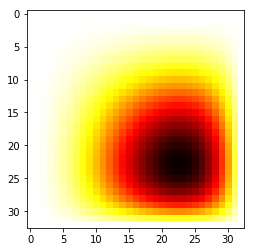

In [17]:
plt.imshow(r3, cmap='hot'); plt.show();

Como podemos notar, por alguna razón la solución empeoró notablemente en comparación con los métodos anteriores.

Si queremos mejorar los resultados para la resolución de este problema tendremos que generar un 
algoritmo especifico que utilice todas las caracteristicas que conocemos de la ecuación.

En primer lugar, para solucionar el problema de uso de memoria no se resolverá el problema $Ax = b$,
en vez de ello, calcularemos la solución directamente en la malla.

Por Gauss-Seidel sabemos que cada punto se puede calcular como:

\begin{align}
 (D + L)x^{k+1} &= b - Ux^k \\
 Dx^{k+1} &= b - Ux^k - Lx^{k+1}\\
 -4x^{k+1} &= \Delta^2 g(x_i,y_j) - (x^{k}_{i+1,j} + x^{k}_{i,j+1}) - (x^{k+1}_{i−1,j} + x^{k+1}_{i,j−1})\\
  x^{k+1} &=  \frac{x^{k}_{i+1,j} + x^{k}_{i,j+1} + x^{k+1}_{i−1,j} + x^{k+1}_{i,j−1} - \Delta^2 g(x_i,y_j)}{4}
\end{align}

Así, se genera un algoritmo iterativo que solo requiere el número de puntos de la malla.

Como criterio de termino utilizaremos la norma 2 de la diferencia de dos iteraciones consecutivas.

In [358]:
def my_gs(n, x = None, maxit = MAXIT, info = {}):
    """ Resuelve el problema especifico de este trabajo con el método de Gauss-Seidel.
    Calcula la malla final iterativamente.
    Argumentos:
        n      -- Número de nodos de la malla por dimensión.
        x      -- (Opcional) Malla inicial, por defecto 0.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Matriz con la malla solución."""
    if not isinstance(x, np.ndarray): x = np.zeros(shape=(n,n));
    info["time"] = time.time();
    dx = get_dx(n);
    for k in range(maxit):
        diff = 0.0;
        x2prev = np.sum(x**2);
        for i in range(1,n-1):
            for j in range(1,n-1):
                prev = x[i][j];
                x[i][j] = .25 * (x[i+1][j] + x[i-1][j] + x[i][j+1] + x[i][j-1] - g(dx*i, dx*j) * dx**2);
                diff += (x[i][j] - prev)**2;
        diff = np.sqrt(diff/(x2prev + 1e-15));
        if diff < TOL: break;
    info["loop"]  = k + 1;
    info["time"]  = (time.time() - info["time"])*1000.0;
    info["res"] = diff;
    info["result"] = x;
    return x;

In [19]:
r4 = my_gs(65);

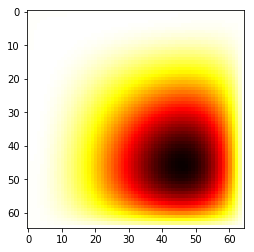

In [20]:
plt.imshow(r4, cmap='hot'); plt.show();

 Con todos los Gauss-Seidel implementados, comparamos los resultados de la ejecución para decidir cual utilizaremos para los siguientes ejercicios.

In [21]:
ns  = [17,33,65, 81, 97]; #Pruebas generales
info = {};

for n in ns:
    info[n] = {"gs": {}, "gs2": {}, "gss": {}, "my_gs": {}};
    A, As, b = get_A(n), get_A(n, sparse=True), get_b(n);
    gs(A,b, info=info[n]["gs"]);
    gs2(A,b, info=info[n]["gs2"]);
    gs(As,b, info=info[n]["gss"]);
    my_gs(n, info=info[n]["my_gs"]);

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


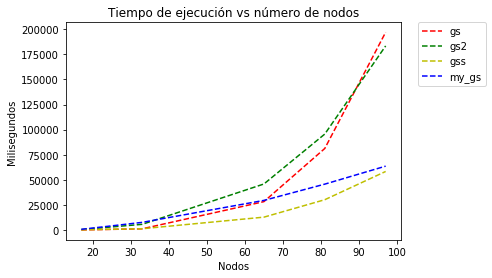

In [46]:
times = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    times[method] = [info[n][method]["time"] for n in ns];
    
plt.plot(ns, times["gs"], 'r--', label="gs");
plt.plot(ns, times["gs2"], 'g--', label="gs2");
plt.plot(ns, times["gss"], 'y--', label="gss");
plt.plot(ns, times["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

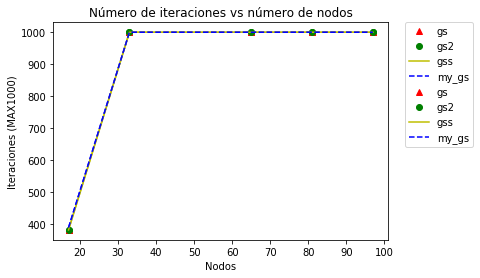

In [41]:
iters = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    iters[method] = [info[n][method]["loop"] for n in ns];
    
plt.plot(ns, iters["gs"], 'r^', label="gs");
plt.plot(ns, iters["gs2"], 'go', label="gs2");
plt.plot(ns, iters["gss"], 'y', label="gss");
plt.plot(ns, iters["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Iteraciones (MAX'+ str(MAXIT) +')')
plt.title('Número de iteraciones vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

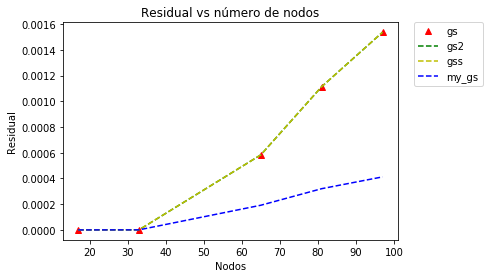

In [24]:
rest = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    rest[method] = [info[n][method]["res"] for n in ns];
    
plt.plot(ns, rest["gs"], 'r^', label="gs");
plt.plot(ns, rest["gs2"], 'g--', label="gs2");
plt.plot(ns, rest["gss"], 'y--', label="gss");
plt.plot(ns, rest["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Residual')
plt.title('Residual vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

Como podemos ver, el método implementado especificamente para este problema es el que tiene mejores resultados en todos los ambitos. Por alguna razón, la ejecución de Gauss-Seidel con matrices sparse no es capaz de calcular el error correctamente lo que hace que el metodo no pueda ser utilizado.

## V-cycle

La idea detras de *v-cycle* es la utilización de resultados del problema en mallas más gruesas como aproximación inicial para una malla mucho más fina.

El algoritmo se define recursivamente como sigue:

$$ v^h \leftarrow V^h(v^h, f^h)$$
1. Relajar $v_1$ veces $A^hu^h=f^h$ con una aproximación inicial $v^h$.
1. Si $\Omega^{h}$ es la malla más gruesa ir al paso 4. Si no:
    - $ f^{2h} \leftarrow I_h^{2h} (f^h - A^hv^h)$,
    - $ v^{2h} \leftarrow 0 $, 
    - $ v^{2h} \leftarrow V^{2h}(v^{2h}, f^{2h}) $.
1. Corregir $v^{h} \leftarrow v^h + I_{2h}^{h} v^{2h}$.
1. Relajar $v_2$ veces $A^hu^h=f^h$ con una aproximación inicial $v^h$.

In [279]:
S = np.array([
    [1,2,1],
    [2,1,2],
    [1,2,1]
]);
V = np.array([[3],[3],[3]])
S*(2*V)

array([[ 6, 12,  6],
       [12,  6, 12],
       [ 6, 12,  6]])

In [184]:
def injection(A):
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            R[i][j] = A[2*i][2*j];
    return R;

In [259]:
def half_weighting(A):
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                R[i][j] = A[2*i][2*j];
            else:
                R[i][j] = (A[2*i+1][2*j]+A[2*i-1][2*j]+A[2*i][2*j+1]+A[2*i][2*j-1]+4*A[2*i][2*j])/8
    return R;

In [260]:
def full_weighting(A):
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                R[i][j] = A[2*i][2*j];
            else:
                R[i][j] = (
                    A[2*i+1][2*j+1]+A[2*i-1][2*j-1]+A[2*i-1][2*j+1]+A[2*i+1][2*j-1] 
                    + 2*(A[2*i+1][2*j]+A[2*i-1][2*j]+A[2*i][2*j+1]+A[2*i][2*j-1])
                    + 4*A[2*i][2*j])/16
    return R;

In [194]:
def linear_interpolation(A):
    m, n = A.shape
    R = np.empty((2*m-1, 2*n-1), float)
    R[0:  :2, 0:  :2] = A[0: ,0: ];
    R[1:-1:2, 0:  :2] = 0.5 * (A[0:-1,0:  ] + A[1: ,0: ]);
    R[0:  :2, 1:-1:2] = 0.5 * (A[0:  ,0:-1] + A[0: ,1: ]);
    R[1:-1:2, 1:-1:2] = 0.25* (A[0:-1,0:-1] + A[1: ,0:-1] + A[0:-1,1: ] + A[1: ,1: ]);
    return R

In [362]:
def vcycle(n, A = None, b = None, x = None, v1=2, v2=2, restrict=full_weighting):
    dx = get_dx(n);
    if not isinstance(A, np.ndarray): A = get_A(n, sparse=True);
    if not isinstance(b, np.ndarray): b = get_b(n);
    if not isinstance(x, np.ndarray): x = np.zeros(shape=(n,n));

    #primera relajación
    x = my_gs(n, x, maxit=v1);
    if n > 7:
        r = b - A.dot(x[1:-1,1:-1].flatten());
        r = mk_appr(r);
        r2 = restrict(r)
        e2 = vcycle(r2.shape[0], b=r2[1:-1,1:-1].flatten(), v1=v1, v2=v2); #why not use r2 as x0?
        e = linear_interpolation(e2);
        x = x + e;
    #segunda relajación
    return my_gs(n, x=x, maxit=v2);

In [119]:
def get_r(A, b, x):
    return np.sqrt(np.sum((b - A.dot(x[1:-1,1:-1].flatten()))**2));

In [280]:
def get_err(A, X):
    return np.linalg.norm(A-X);

In [347]:
def vcycle_tol(n, x = None, v1=2, v2=2, restrict=full_weighting):
    A = get_A(n);
    b = get_b(n);
    S = mk_sol(n);
    for _ in range(15):
        x = vcycle(n, A, b, x, v1, v2, restrict);
        r = get_r(A,b,x);
        print(r, get_err(S, x));
        if r < TOL: break;
    #print(_);
    return x;

In [299]:
def gs_tol(n):
    A = get_A(n);
    b = get_b(n);
    S = mk_sol(n);
    x = my_gs(n, maxit=2)
    for _ in range(15):
        x = my_gs(n, x=x, maxit=2);
        print(get_r(A, b, x), get_err(S, x));

In [360]:
vcycle(65);

In [349]:
vcycle_tol(65);

0.0175797439205 1.41370733457
0.018880070461 1.29353450794
0.0205653572154 1.28616068069
0.0224832014252 1.38937931025
0.0245291600825 1.57832939749
0.0266376749616 1.82382094442
0.0287682954564 2.10386992943
0.0308961638373 2.40450653057
0.0330060517746 2.71726453772
0.0350887130453 3.03698651433
0.0371386555427 3.36045288138
0.0391527686086 3.68559404965
0.0411294665959 4.01104152662
0.0430681470335 4.33586748647
0.0449688430691 4.65942948828


In [300]:
gs_tol(65);

0.0158462075435 1.60053618526
0.0154969285619 1.58837690751
0.0151836249403 1.57639184144
0.0148976198847 1.56457555876
0.01463291816 1.55292287264
0.0143854422842 1.54142890895
0.0141523109118 1.53008910114
0.0139314061013 1.5188991659
0.0137211174455 1.50785507544
0.0135201854051 1.49695303149
0.01332760142 1.48618944198
0.0131425417805 1.47556090086
0.01296432237 1.46506417046
0.0127923667799 1.45469616623
0.0126261832719 1.44445394351


## Multigrid

Definido como siguie:

$$ v^h \leftarrow FMG^h(f^h) $$
1. Si $\Omega^h$ es la malla más gruesa, hacer $v^h \leftarrow 0$ y ir al paso 3. Si no:
    - $f^{2h} \leftarrow I_{h}^{2h}(f^h)$
    - $v^{2h} \leftarrow FMG^{2h}(f^{2h})$
2. Corregir $v^h \leftarrow I^h_{2h}v^{2h}$
3. Hacer $v^h \leftarrow V^h(v^h, f^h)$ $v_0$ veces.

In [370]:
def mg(x = None, v1=2, v2=2, v0=1):
    if isinstance(x, np.ndarray):
        n = x.shape[0];
    elif isinstance(x, int):
        n = x;
        x = np.zeros(shape=(n,n));
    else:
        raise ValueError("x must be an int or np.array");

    if n > 7: #Si no estamos en la malla más gruesa
        x2 = restrict_hw(x);
        x2 = mg(x2, v1, v2, v0);
        x = prolong_lin(x2);
    for _ in range(v0):
        x = vcycle(n, x=x, v1=v1, v2=v2);
    return x;

## Comparaciones

In [207]:
def vc_info(n, x = None, v1=2, v2=2, info={}):
    info["time"]   = time.time();
    info["result"] = vcycle(n,x,v1,v2);
    info["time"]   = (time.time() - info["time"])*1000.0;
    return info["result"];

def mg_info(n, v1=2, v2=2, v0=1, info={}):
    info["time"]   = time.time();
    info["result"] = mg(n,v1,v2,v0);
    info["time"]   = (time.time() - info["time"])*1000.0;
    return info["result"];

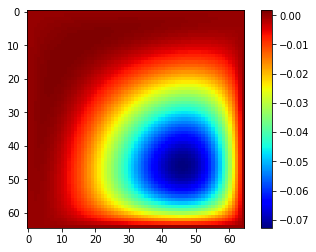

In [374]:
plt.imshow(vcycle(65), cmap='jet'); plt.colorbar(); plt.show();

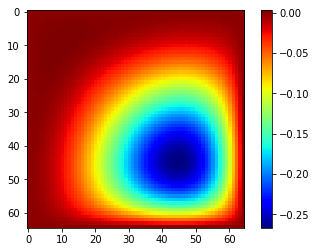

In [372]:
plt.imshow(mg(65), cmap='jet'); plt.colorbar(); plt.show();

In [90]:
#ns  = [17,33,65, 81, 97];
info2 = {};

for n in ns:
    info2[n] = {"gs": {}, "vc": {}, "mg": {}};
    my_gs(n, info=info2[n]["gs"]);
    vc_info(n, info=info2[n]["vc"]);
    mg_info(n, info=info2[n]["mg"]);

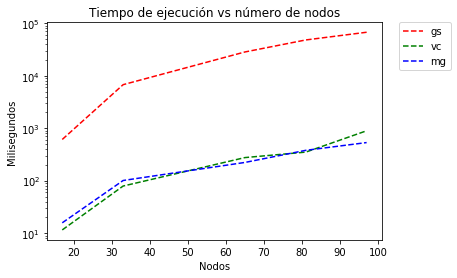

In [102]:
times2 = {};
for method in ["gs", "vc", "mg"]:
    times2[method] = [info2[n][method]["time"] for n in ns];
    
plt.plot(ns, times2["gs"], 'r--', label="gs");
plt.plot(ns, times2["vc"], 'g--', label="vc");
plt.plot(ns, times2["mg"], 'b--', label="mg");
plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');

plt.show();

In [94]:
#ns  = [17,33,65, 81, 97];
for n in ns:
    info2[n]["a"] = {"result": mk_sol(n)}; #soluciones analíticas

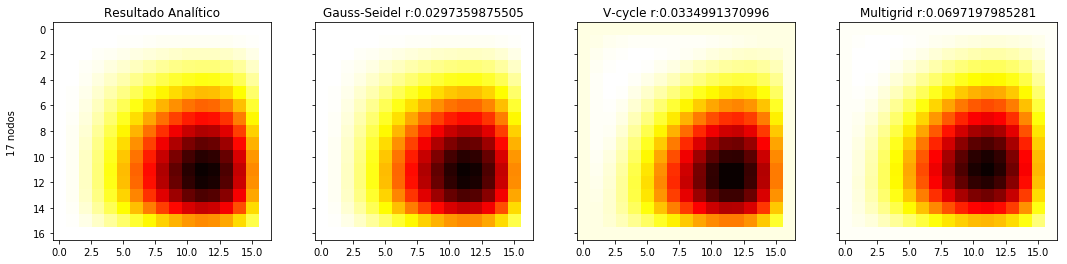

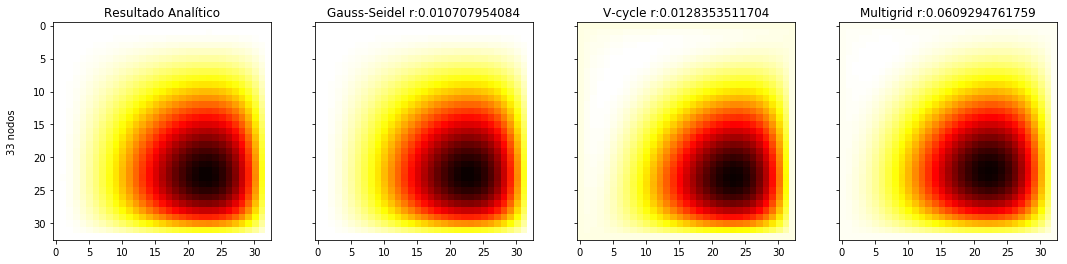

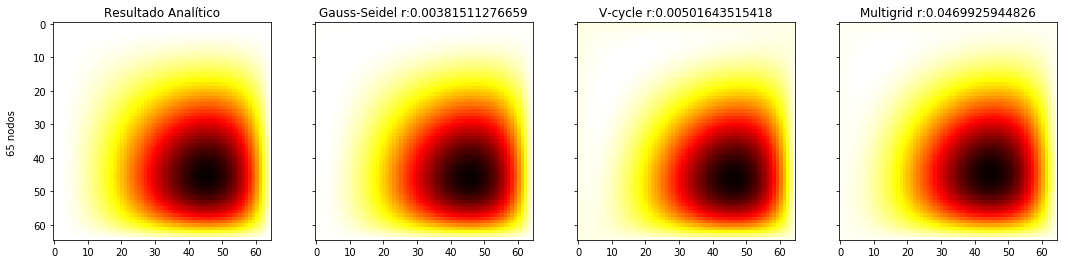

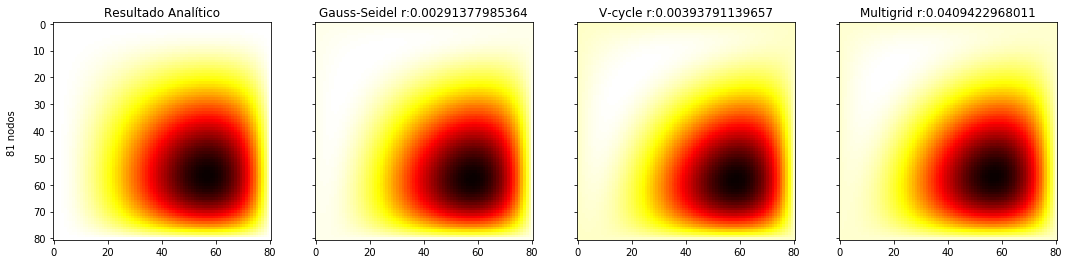

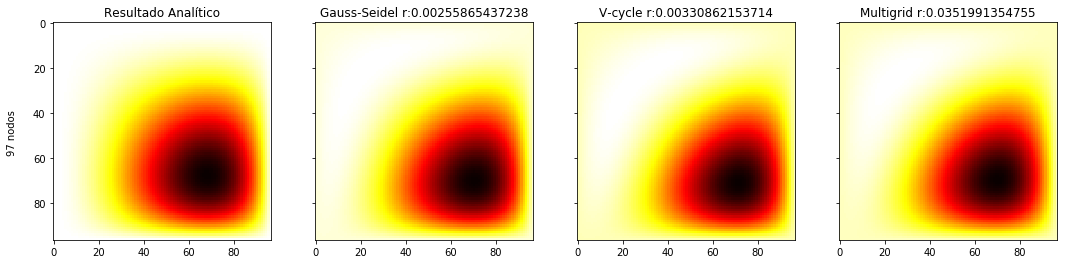

In [108]:
for n in ns:
    A = get_A(n, sparse=True);
    b = get_b(n);
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18,4));
    ax1.imshow(info2[n]["a"]["result"], cmap='hot');
    ax1.set_title('Resultado Analítico');
    x = info2[n]["gs"]["result"];
    ax2.imshow(x, cmap='hot');
    ax2.set_title("Gauss-Seidel r:" + str(get_r(A, b, x)) );
    x = info2[n]["vc"]["result"];
    ax3.imshow(x, cmap='hot');
    ax3.set_title("V-cycle r:" + str(get_r(A, b, x)) );
    x = info2[n]["mg"]["result"];
    ax4.imshow(x, cmap='hot');
    ax4.set_title("Multigrid r:" + str(get_r(A, b, x)) );
    f.text(0.09, 0.5, str(n) + ' nodos', va='center', rotation='vertical')
    plt.show()

In [203]:
#Tiempo vcycle vs mg:
vct = [];
mgt = [];
tmp = {}
for n in nodes:
    vc_info(n, info=tmp);
    vct.append(tmp["time"]);
    mg_info(n, info=tmp);
    mgt.append(tmp["time"]);

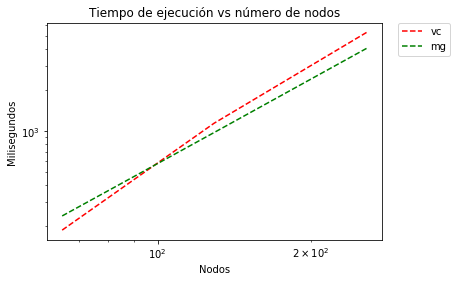

In [204]:
plt.plot(nodes, vct, 'r--', label="vc");
plt.plot(nodes, mgt, 'g--', label="mg");

plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');
plt.xscale('log');

plt.show();

In [214]:
#vtest
vresult = {};
vtime = {};
ntest = 33;
v0s = [1,2,4,8];
v1s = [2,4,8,16];
v2s = [2,4,8,16];
for i in v0s:
    vresult[i] = {};
    vtime[i] = {};
    for j in v1s:
            vresult[i][j] = {};
            vtime[i][j] = {};

In [216]:
tmp = {};
for i in v0s:
    for j in v1s:
        for k in v2s:
            vresult[i][j][k] = mg_info(ntest, info=tmp);
            vtime[i][j][k] = tmp["time"];

In [217]:
vtime

{1: {2: {2: 118.22390556335449,
   4: 115.33617973327637,
   8: 115.76175689697266,
   16: 115.19551277160645},
  4: {2: 114.53914642333984,
   4: 114.23134803771973,
   8: 113.65699768066406,
   16: 109.75122451782227},
  8: {2: 57.84487724304199,
   4: 58.400869369506836,
   8: 57.181596755981445,
   16: 58.23993682861328},
  16: {2: 58.2120418548584,
   4: 57.3430061340332,
   8: 57.349443435668945,
   16: 58.783531188964844}},
 2: {2: {2: 58.63332748413086,
   4: 57.55782127380371,
   8: 56.79011344909668,
   16: 55.850982666015625},
  4: {2: 56.45895004272461,
   4: 56.7774772644043,
   8: 58.26830863952637,
   16: 57.028770446777344},
  8: {2: 57.343482971191406,
   4: 56.932687759399414,
   8: 57.27863311767578,
   16: 57.274580001831055},
  16: {2: 57.54280090332031,
   4: 57.10411071777344,
   8: 56.90956115722656,
   16: 57.688236236572266}},
 4: {2: {2: 56.82945251464844,
   4: 56.288719177246094,
   8: 56.797027587890625,
   16: 56.22267723083496},
  4: {2: 57.3785305023193

## Conclusiones

TODO
